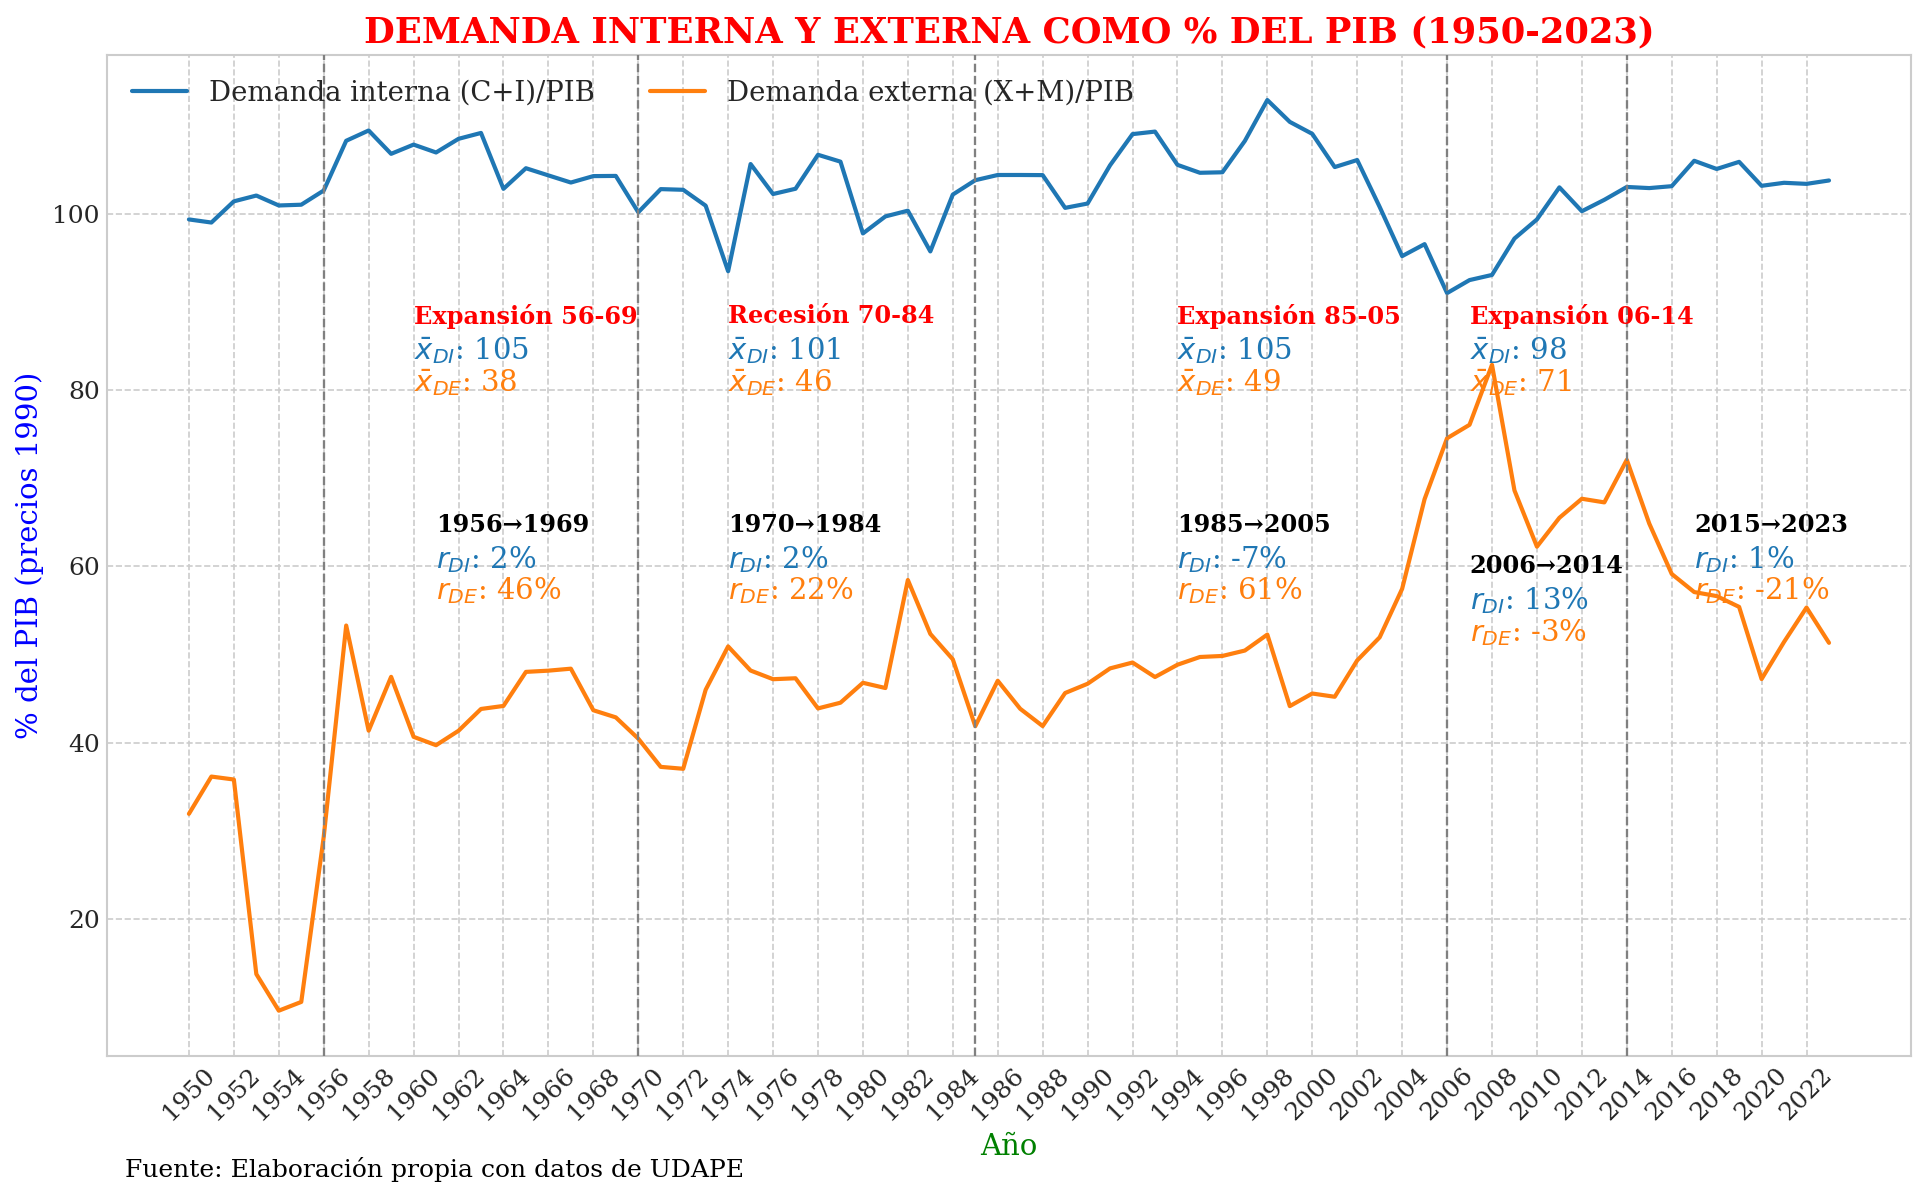

In [3]:
# ─────────────────────────────────────────────────────────────────────
# Demanda interna vs demanda externa  (1950-2023)  –  Ratio sobre PIB
# Estructura alineada a “Estructura Graficas.pdf”
# ─────────────────────────────────────────────────────────────────────

import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from func_auxiliares.graficos_utils import (
    set_style, init_base_plot,
    add_hitos, add_year_value_annotations,
    add_cycle_means_multi, add_period_growth_annotations_multi,
    adjust_annot_years, adjust_cycles, adjust_periods
)
from func_auxiliares.config import (
    ASSETS_DIR, DB_PATH,
    CYCLES_SIN_CRISIS, hitos_v_sin_crisis,
    annot_years_sin_crisis, periodos_tasas_sin_crisis,
)

# ─────────────────────────────────────────────────────────────
# 1. Configuración general
# ─────────────────────────────────────────────────────────────
output_dir = ASSETS_DIR / "serie_completa" / "demanda_ratios"
output_dir.mkdir(parents=True, exist_ok=True)
set_style()

# ─────────────────────────────────────────────────────────────
# 2. Carga de datos reales (miles de Bs 1990)
# ─────────────────────────────────────────────────────────────
SQL = """
SELECT año,
       gastos_consumo,
       formacion_capital,
       exportacion_bienes_servicios,
       importacion_bienes,
       pib_real_base_1990
FROM pib_real_gasto
"""
with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql(SQL, conn, index_col="año").sort_index()

# ─────────────────────────────────────────────────────────────
# 3. Cálculo de ratios sobre PIB
# ─────────────────────────────────────────────────────────────
df["demanda_interna"]  = (
    (df["gastos_consumo"] + df["formacion_capital"]) / df["pib_real_base_1990"] * 100
)
df["demanda_externa"]  = (
    (df["exportacion_bienes_servicios"] + df["importacion_bienes"]) / df["pib_real_base_1990"] * 100
)

# ─────────────────────────────────────────────────────────────
# 4. Componentes, abreviaturas, colores
# ─────────────────────────────────────────────────────────────
componentes = [
    ("demanda_interna", "Demanda interna (C+I)/PIB"),
    ("demanda_externa", "Demanda externa (X+M)/PIB"),
]
cols_componentes = [c for c, _ in componentes]

colors = {
    "demanda_interna": "#1f77b4",   # azul
    "demanda_externa": "#ff7f0e",   # naranja
}
abbr = {"demanda_interna": "DI", "demanda_externa": "DE"}

# ─────────────────────────────────────────────────────────────
# 5. Preparación de ciclos y periodos
# ─────────────────────────────────────────────────────────────
annot_years   = adjust_annot_years(df, annot_years_sin_crisis)
cycles        = adjust_cycles(df, CYCLES_SIN_CRISIS)
cycle_stats   = {n: df.loc[s, cols_componentes].mean().to_dict()
                 for n, s in cycles.items()}
periodos      = adjust_periods(df, periodos_tasas_sin_crisis)

# ─────────────────────────────────────────────────────────────
# 6. Offsets (puedes refinarlos luego)
# ─────────────────────────────────────────────────────────────
annotation_offsets = {
    "demanda_interna":  {},   # {año: (dx, dy)}
    "demanda_externa":  {},
}
hitos_offset   = {a: 0.80 for a in hitos_v_sin_crisis}
medias_offsets = {
    "Expansión 56-69": (1960, 0.76),
    "Recesión 70-84":  (1974, 0.76),
    "Expansión 85-05": (1994, 0.76),
    "Expansión 06-14": (2007, 0.76),
    "Recesión 15-24":  (2017, 0.76),
}
tasas_offsets  = {
    "1956-1969": (1961, 0.56),
    "1970-1984": (1974, 0.56),
    "1985-2005": (1994, 0.56),
    "2006-2014": (2007, 0.52),
    "2015-2023": (2017, 0.56),
}

# ─────────────────────────────────────────────────────────────
# 7. Gráfica
# ─────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df, componentes, colors,
    title="DEMANDA INTERNA Y EXTERNA COMO % DEL PIB (1950-2023)",
    xlabel="Año",
    ylabel="% del PIB (precios 1990)",
    source_text="Fuente: Elaboración propia con datos de UDAPE"
)

add_hitos(ax, df.index, hitos_v_sin_crisis, hitos_offset)

add_year_value_annotations(
    ax, df, annot_years, cols_componentes,
    annotation_offsets, colors
)

# Medias por ciclo
y_max      = ax.get_ylim()[1]
line_space = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr, colors, line_space
)

# Tasas de crecimiento por periodo (opcional)
add_period_growth_annotations_multi(
    ax, df, periodos, cols_componentes,
    tasas_offsets, colors, abbr
)

# ─────────────────────────────────────────────────────────────
# 8. Guardar
# ─────────────────────────────────────────────────────────────
output_file = output_dir / "demanda_interna_externa_ratio.png"
#plt.savefig(output_file)
plt.show()
